In [349]:
import sys

!{sys.executable} -m pip install tqdm

## Rough Notes
1. Read the dataset and analzye the quantity of type A tomatoes
2. We only consider entries from 19/02/2020 till 29/05/2020 since all teams have data within that timeframe.
3. We take into account type A tomatoes which can be commercially traded.
4. Weather dataset had 71 null values 
5. Train without outlier analysis + Train with outlier analysis
6. Cannot do seasonal analysis since dataset does not contain a cycle and only contains 6 months data.

## Import libraries

In [450]:
import math
import pandas as pd
import xlrd
from datetime import datetime
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy.stats as st

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import validation_curve, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor

from tqdm import tqdm

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Bidirectional

pd.options.mode.chained_assignment = None

## Choice of dataset
We have datasets from 6 teams and to build our model we need to pick the dataset generated by the team which produces the most type A tomatoes since that has the optimum parameters. Below, we analyse the total production of type A tomatoes across the different teams to chose the dataset with which we work on during model building.

In [351]:
# load a csv file and convert it to a pandas dataframe
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    return df

# convert from excel date format to datetime
def convert_xldate_to_date(xl_date):
    datetime = xlrd.xldate_as_datetime(xl_date, 0)
    date = datetime.date()
    return date

# preprocess the production data
def preprocess_prod_df(df):
    # remove rows for which all entries are NaN
    df = df.dropna(axis=0, how="all")
    # convert excel date entries into datetime  
    df["time"] = df["time"].apply(lambda x: convert_xldate_to_date(x))
    # convert kg/m to kg 
    df["ProdA"] = df["ProdA"].apply(lambda x: x*62.5)
    # set the index of the df to time
    df.set_index("time", inplace=True)
    return df

# get the total amount of type A tomatoes produced 
def get_production(df):
    from_date = datetime.strptime("2020-02-19", "%Y-%m-%d").date()
    to_date = datetime.strptime("2020-05-29", "%Y-%m-%d").date()
    total_prod = df.loc[from_date:to_date, "ProdA"].sum()
    return total_prod

### Load, preprocess and extract the total amount of type tomatoes by each team

In [352]:
# team TheAutomators
the_automators_df = load_data("../dataset/automators_production.csv")
the_automators_df = preprocess_prod_df(the_automators_df)
automators_produce = get_production(the_automators_df)

# team Grower
grower_df = load_data("../dataset/grower_production.csv")
grower_df = preprocess_prod_df(grower_df)
grower_produce = get_production(grower_df)

# team Digilog
digilog_df = load_data("../dataset/digilog_production.csv")
digilog_df = preprocess_prod_df(digilog_df)
digilog_produce = get_production(digilog_df)

# team AICU
aicu_df = load_data("../dataset/aicu_production.csv")
aicu_df = preprocess_prod_df(aicu_df)
aicu_produce = get_production(aicu_df)

# team IUACAAS
iuacaas_df = load_data("../dataset/iuacaas_production.csv")
iuacaas_df = preprocess_prod_df(iuacaas_df)
iuacaas_produce = get_production(iuacaas_df)

# team Automatoes
automatoes_df = load_data("../dataset/automatoes_production.csv")
automatoes_df = preprocess_prod_df(automatoes_df)
automatoes_produce = get_production(automatoes_df)

In [353]:
# visualize the dataset from 1 team

the_automators_df

,ProdA,ProdB,avg_nr_harvested_trusses,Truss development time,Nr_fruits_ClassA,Weight_fruits_ClassA,Nr_fruits_ClassB,Weight_fruits_ClassB
time,,,,,,,,
2020-02-19,2.3125,0.000,0.1,50.0,NaN,128.0,0,0
2020-02-24,47.9375,0.000,0.9,54.5,136.0,1271.0,0,0
2020-02-28,14.5000,0.000,0.6,51.0,89.0,788.0,0,0
2020-03-04,48.6250,0.000,1.5,55.1,226.0,2001.0,0,0
2020-03-09,15.5000,0.000,0.9,53.6,133.0,1144.0,0,0
2020-03-13,22.1250,0.000,0.7,52.4,83.0,811.0,0,0
2020-03-18,49.6875,0.000,1.0,53.3,126.0,1230.0,0,0
2020-03-23,30.3750,0.000,0.9,54.9,148.0,1297.5,0,0
2020-03-27,28.3750,0.000,0.9,52.6,126.0,1069.0,0,0


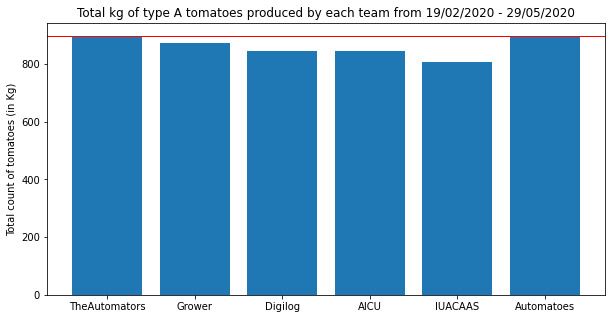

In [354]:
teams = ["TheAutomators", "Grower", "Digilog", "AICU", "IUACAAS", "Automatoes"]
# store the total produce of type A tomatoes for each team
total_produce = [automators_produce, grower_produce, digilog_produce, aicu_produce, iuacaas_produce, automatoes_produce]
# set the threshold to the maximum amount of type A tomatoes produced
threshold = np.array(total_produce).max()

plt.figure(figsize=(10,5))
plt.bar(teams, total_produce)
plt.axhline(y=threshold, linewidth=1, color='r')
plt.title("Total kg of type A tomatoes produced by each team from 19/02/2020 - 29/05/2020")
plt.ylabel("Total count of tomatoes (in Kg)")
plt.show()

### Finding

Since **TheAutomators** and **Automatoes** yeild the highest amout of tomatoes during the given time period, we want to consider their environment conditions (especially the **GreenHouse Climate** conditions) to train an efficient forecasting model. However, if our model is underfit, then we can also include the dataset from
remaining teams as well since the margin of difference is rather small. 

<span style="color:red">Suggestion</span>:

We can decide on a threshold, based on the amount of type A tomatoes generated, which "qualifies" a team's dataset and in turn it's environmental conditions as gold standard such that only these conditions can be taken into account during training a ML/DNN model. 

## Predict the greenhouse air temperature for the next 24h in every 1h intervals

### Load and transform the weather dataset

In [355]:
# convert from excel date format to datetime
def convert_xldate_to_datetime(xl_date):
    datetime = xlrd.xldate_as_datetime(xl_date, 0)
    return datetime

def preprocess(df):
    # convert excel date entries into datetime  
    df["time"] = df["time"].apply(lambda x: convert_xldate_to_datetime(x))
    # set the index of the df to time
    df.set_index("time", inplace=True)
    # remove rows for which all entries are NaN
    df = df.dropna(axis=0, how="all")
     # downsample the dataset to hourly intervals
    df = df.resample('H').ffill()
    # convert Rain to categorical variable
    if "Rain" in df.columns:
        df["Rain"] = df.Rain.astype('int')
        df["Rain"] = df.Rain.astype('category')
        # one-hot encode the categorical column
        df = pd.get_dummies(df, columns=['Rain'])
    return df

def transform(df_a, df_b):
    # fetch only the time and Tair column from the greenhouse dataset
    df_a.reset_index(inplace=True)
    df_b.reset_index(inplace=True)
    df_b = df_b[['time', 'Tair']]
    df = pd.merge(df_a, df_b, on='time', how='inner')
    df.set_index("time", inplace=True)
    df.dropna(inplace=True)
    return df

In [356]:
weather_df = load_data("../dataset/weather.csv")

In [357]:
weather_df

,time,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rain,Rhout,Tout,Winddir,Windsp
0,43815.00000,6.220954,0.0,0.000000e+00,-72.0,215.0,0.0,80.6,6.9,32.0,4.7
1,43815.00347,6.220954,0.0,0.000000e+00,-73.0,0.0,0.0,80.6,6.9,32.0,4.7
2,43815.00694,6.205565,0.0,0.000000e+00,-76.0,0.0,0.0,80.4,6.9,32.0,4.7
3,43815.01042,6.190173,0.0,0.000000e+00,-77.0,0.0,0.0,80.2,6.9,32.0,4.7
4,43815.01389,6.162624,0.0,0.000000e+00,-75.0,0.0,0.0,80.9,6.7,32.0,4.7
...,...,...,...,...,...,...,...,...,...,...,...
47804,43980.98611,9.286397,0.0,9.999999e-01,-85.0,2992.0,0.0,71.4,15.1,2.0,4.3
47805,43980.98958,9.242139,0.0,1.000000e+00,-85.0,2992.0,0.0,71.5,15.0,2.0,4.3
47806,43980.99306,9.152067,0.0,3.350000e-08,-84.0,2992.0,0.0,70.8,15.0,2.0,3.8
47807,43980.99653,9.177802,0.0,0.000000e+00,-85.0,2992.0,0.0,71.0,15.0,2.0,3.8


In [358]:
# visualize the datatypes 
weather_df.dtypes

time         float64
AbsHumOut    float64
Iglob        float64
PARout       float64
Pyrgeo       float64
RadSum       float64
Rain         float64
Rhout        float64
Tout         float64
Winddir      float64
Windsp       float64
dtype: object

In [359]:
# count of null entires in the dataset
weather_df.isnull().sum()

time          0
AbsHumOut    71
Iglob        71
PARout       71
Pyrgeo       71
RadSum       71
Rain         71
Rhout        71
Tout         71
Winddir      71
Windsp       71
dtype: int64

In [360]:
weather_df = preprocess(weather_df)

In [361]:
weather_df

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rhout,Tout,Winddir,Windsp,Rain_0,Rain_1
time,,,,,,,,,,,
2019-12-16 00:00:00,6.220954,0.000000,0.000000e+00,-72.0,215.0,80.6,6.9,32.0,4.7,1,0
2019-12-16 01:00:00,6.253760,0.000000,0.000000e+00,-72.0,0.0,82.1,6.7,16.0,3.2,1,0
2019-12-16 02:00:00,6.271813,0.000000,0.000000e+00,-61.0,0.0,85.1,6.2,16.0,2.7,1,0
2019-12-16 03:00:00,6.383868,0.000000,0.000000e+00,-57.0,0.0,87.2,6.1,16.0,3.3,1,0
2019-12-16 04:00:00,6.507935,0.000000,0.000000e+00,-46.0,0.0,88.9,6.1,16.0,3.6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29 19:00:00,6.792019,366.000000,6.990000e+02,-105.0,2838.0,38.0,20.3,2.0,4.2,1,0
2020-05-29 20:00:00,7.283439,191.000001,3.640000e+02,-102.0,2944.0,42.0,19.8,2.0,4.2,1,0
2020-05-29 21:00:00,8.536842,54.999999,1.070000e+02,-94.0,2985.0,53.6,18.4,2.0,3.7,1,0


In [362]:
weather_df.isnull().sum()

AbsHumOut    0
Iglob        0
PARout       0
Pyrgeo       0
RadSum       0
Rhout        0
Tout         0
Winddir      0
Windsp       0
Rain_0       0
Rain_1       0
dtype: int64

In [363]:
# numerical_columns = weather_df.columns.drop('Rain')

In [364]:
weather_df.describe()

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rhout,Tout,Winddir,Windsp,Rain_0,Rain_1
count,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000
mean,6.569513,125.379518,251.254518,-52.795683,495.216362,74.871637,9.019076,28.506526,4.984990,0.952058,0.047942
std,1.731364,221.928278,445.079332,36.302291,735.428428,19.831963,4.230289,26.632008,3.847902,0.213670,0.213670
min,1.495718,0.000000,0.000000,-133.000000,0.000000,13.000000,-0.100000,1.000000,0.000000,0.000000,0.000000
25%,5.442200,0.000000,0.000000,-84.000000,0.000000,61.800000,6.300000,4.000000,2.300000,1.000000,0.000000
50%,6.565845,0.000000,1.000000,-53.000000,134.000000,79.300000,8.400000,32.000000,4.200000,1.000000,0.000000
75%,7.693103,147.999997,294.999999,-17.000000,635.250000,91.200000,10.900000,32.000000,7.100000,1.000000,0.000000
max,12.249671,1493.999998,1953.999998,0.000000,2999.000000,99.700000,27.100000,128.000000,21.600000,1.000000,1.000000


### Outlier analysis - Decide on how to handle outliers [Future work]

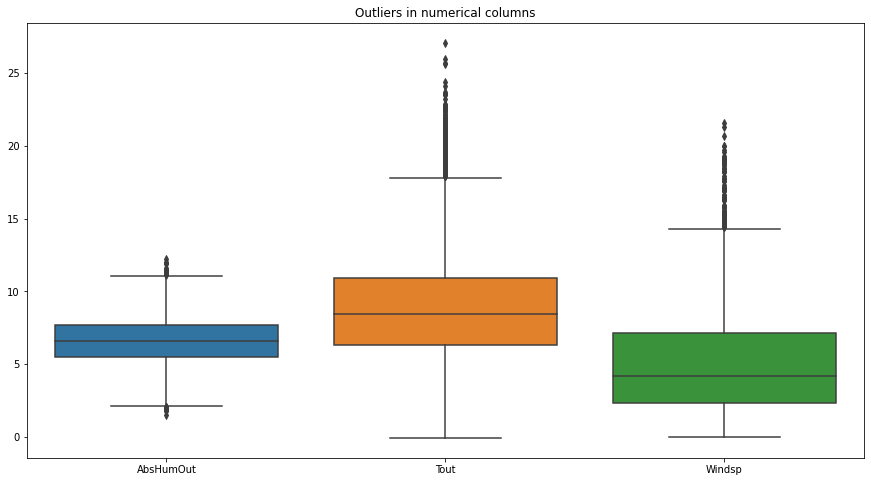

In [365]:
# Outlier analysis - Outside Humidity, Outside temperature, Windspeed

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df[['AbsHumOut', 'Tout', 'Windsp']])
ax.set_title("Outliers in numerical columns")
plt.show()

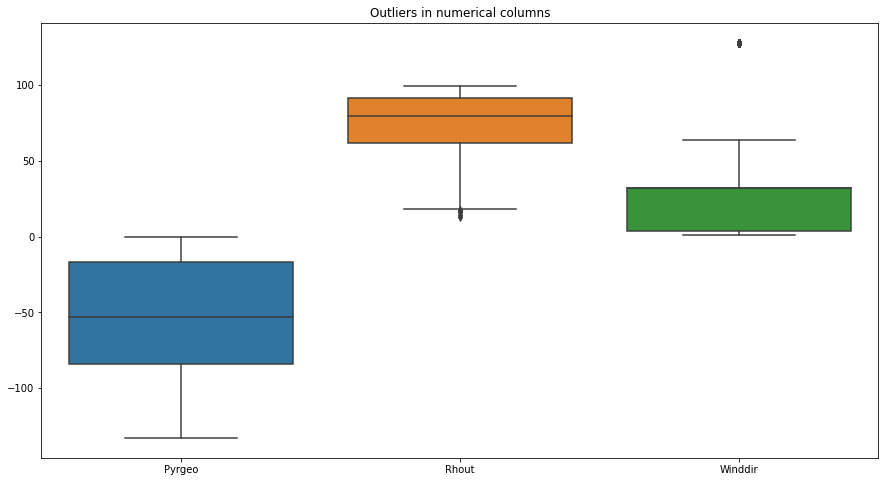

In [366]:
# Outlier analysis - Heat emission, Outside Humidity, Wind direction

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df[['Pyrgeo', 'Rhout', 'Winddir']])
ax.set_title("Outliers in numerical columns")
plt.show()

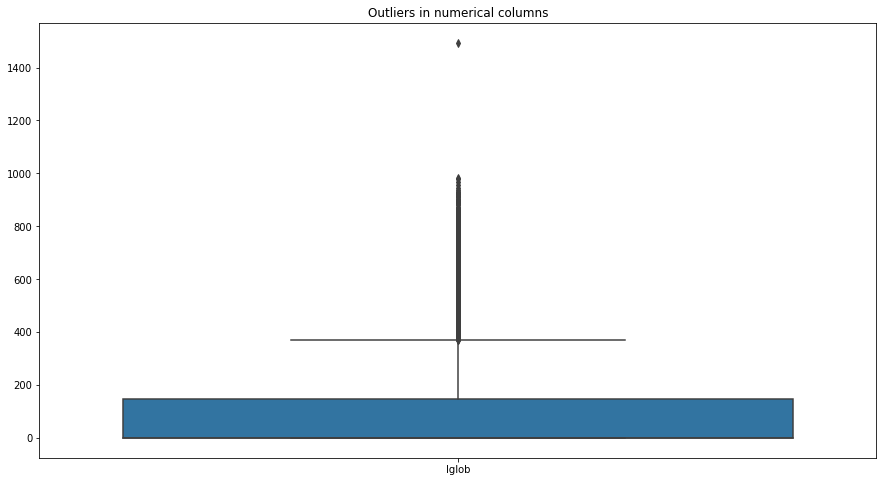

In [367]:
# Outlier analysis - Solar Radiation

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=weather_df[['Iglob']])
ax.set_title("Outliers in numerical columns")
plt.show()

### Load and transform the Automatoes dataset

In [368]:
automatoes_df = load_data("../dataset/ghclimate_automatoes.csv")

In [369]:
automatoes_df

,time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,0.0,35.000000,468.000000,0.26,1.78,96.0,7.32,34.5,50.4,...,NaN,0.0,NaN,25.0,26.0,2.0,NaN,1000.0,NaN,1.2
1,43815.00347,0.0,85.000001,508.999999,0.52,1.78,96.0,7.08,33.2,48.7,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
2,43815.00694,0.0,95.999999,498.000001,0.52,1.78,96.0,7.48,32.4,47.1,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
3,43815.01042,0.0,96.000000,491.000001,0.52,1.76,96.0,6.55,31.7,45.4,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
4,43815.01389,0.0,95.400000,514.999999,0.52,1.78,95.4,6.71,30.9,44.2,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47804,43980.98611,0.0,0.000000,493.000000,2.86,7.84,0.0,3.46,0.0,0.0,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0
47805,43980.98958,0.0,0.000000,493.000000,2.86,7.84,0.0,3.35,0.0,0.0,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0
47806,43980.99306,0.0,0.000000,485.000000,2.86,7.86,0.0,3.26,0.0,0.0,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0
47807,43980.99653,0.0,0.000000,502.000000,2.86,7.85,0.0,3.08,0.0,0.0,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0


In [370]:
automatoes_df.isnull().sum()

time                               0
AssimLight                        71
BlackScr                          71
CO2air                            71
Cum_irr                           71
EC_drain_PC                       71
EnScr                             71
HumDef                            71
PipeGrow                          71
PipeLow                           71
Rhair                             71
Tair                              71
Tot_PAR                           71
Tot_PAR_Lamps                      0
VentLee                           71
Ventwind                          71
assim_sp                         785
assim_vip                         71
co2_dos                            2
co2_sp                           754
co2_vip                           71
dx_sp                            718
dx_vip                            71
int_blue_sp                      173
int_blue_vip                   22152
int_farred_sp                     14
int_farred_vip                 22152
i

In [371]:
automatoes_df = preprocess(automatoes_df)

In [372]:
automatoes_df

,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,Rhair,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
time,,,,,,,,,,,,,,,,,,,,,
2019-12-16 00:00:00,0.0,35.0,468.000000,0.26,1.78,96.0,7.32,34.5,50.4,60.7,...,NaN,0.0,NaN,25.0,26.0,2.0,NaN,1000.0,NaN,1.2
2019-12-16 01:00:00,0.0,96.0,492.000001,0.52,1.76,96.0,6.94,29.7,42.0,62.3,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
2019-12-16 02:00:00,0.0,96.0,488.000001,0.52,1.77,96.0,6.87,30.7,44.3,61.8,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
2019-12-16 03:00:00,0.0,96.0,497.000000,0.00,1.77,96.0,7.03,30.1,43.6,61.8,...,NaN,0.0,NaN,25.0,26.0,0.0,NaN,1000.0,NaN,1.2
2019-12-16 04:00:00,0.0,96.0,510.999998,0.00,1.77,96.0,7.19,30.5,42.3,60.9,...,NaN,0.0,NaN,25.0,26.0,0.0,NaN,1000.0,NaN,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29 20:00:00,0.0,0.0,450.000001,2.86,7.80,0.0,12.56,0.0,0.0,40.9,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0
2020-05-29 21:00:00,0.0,0.0,461.000001,2.86,7.89,0.0,9.46,0.0,0.0,49.2,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0
2020-05-29 22:00:00,0.0,0.0,483.000000,2.86,7.91,0.0,5.86,0.0,0.0,64.4,...,NaN,0.0,18.0,18.0,18.0,22.0,NaN,1080.0,0.0,0.0


## Outlier analysis of Temperature values

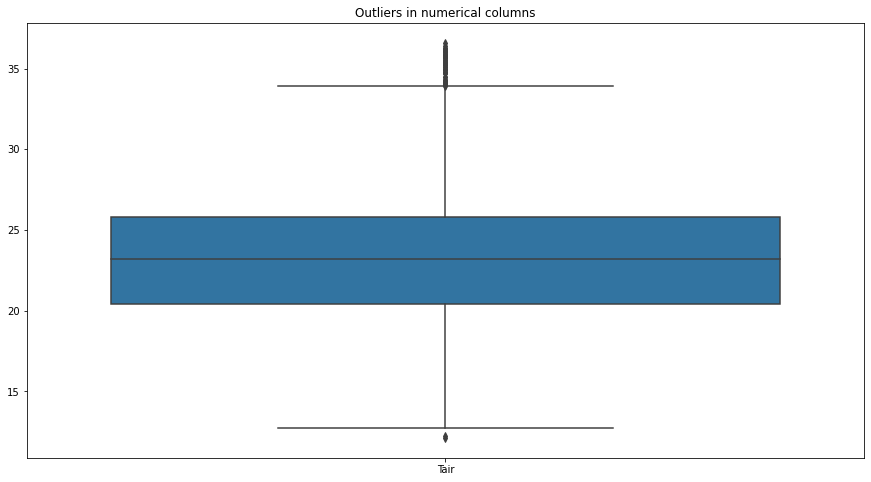

In [373]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=automatoes_df[['Tair']])
ax.set_title("Outliers in numerical columns")
plt.show()

## Transform the 2 dataframes for our task

In [374]:
final_df = transform(weather_df, automatoes_df)

In [375]:
final_df

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rhout,Tout,Winddir,Windsp,Rain_0,Rain_1,Tair
time,,,,,,,,,,,,
2019-12-16 00:00:00,6.220954,0.000000,0.000000e+00,-72.0,215.0,80.6,6.9,32.0,4.7,1,0,21.3
2019-12-16 01:00:00,6.253760,0.000000,0.000000e+00,-72.0,0.0,82.1,6.7,16.0,3.2,1,0,21.1
2019-12-16 02:00:00,6.271813,0.000000,0.000000e+00,-61.0,0.0,85.1,6.2,16.0,2.7,1,0,20.7
2019-12-16 03:00:00,6.383868,0.000000,0.000000e+00,-57.0,0.0,87.2,6.1,16.0,3.3,1,0,21.1
2019-12-16 04:00:00,6.507935,0.000000,0.000000e+00,-46.0,0.0,88.9,6.1,16.0,3.6,1,0,21.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29 19:00:00,6.792019,366.000000,6.990000e+02,-105.0,2838.0,38.0,20.3,2.0,4.2,1,0,27.5
2020-05-29 20:00:00,7.283439,191.000001,3.640000e+02,-102.0,2944.0,42.0,19.8,2.0,4.2,1,0,23.6
2020-05-29 21:00:00,8.536842,54.999999,1.070000e+02,-94.0,2985.0,53.6,18.4,2.0,3.7,1,0,21.3


In [376]:
final_df.dtypes

AbsHumOut    float64
Iglob        float64
PARout       float64
Pyrgeo       float64
RadSum       float64
Rhout        float64
Tout         float64
Winddir      float64
Windsp       float64
Rain_0         uint8
Rain_1         uint8
Tair         float64
dtype: object

## Normalization: Scaling

**Finding**: We do **not** apply scaling on our dataset since the performance of the model degrades with scaling

In [377]:
"""
num_cols = final_df.select_dtypes(include='float64').columns

def scale(data):
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(data[num_cols])

    data.loc[:, num_cols] = X_scaled
    
    return None
"""

"\nnum_cols = final_df.select_dtypes(include='float64').columns\n\ndef scale(data):\n    scaler = StandardScaler()\n\n    X_scaled = scaler.fit_transform(data[num_cols])\n\n    data.loc[:, num_cols] = X_scaled\n    \n    return None\n"

In [378]:
# scale(final_df)

## Split the dataset into train and test

In [379]:
def train_test_split(data, train_size):
    '''
    Parameters
    -----------
    data: dataframe
    train_size: ratio of training data
    '''
    data.reset_index(inplace=True)
    data.drop('time', axis=1, inplace=True)
    
    train_set = data[:int(len(data)*train_size)]
    test_set = data[int(len(data)*train_size):]
    
    train_columns = data.columns.drop('Tair')
    
    X_train, Y_train = train_set[train_columns], train_set['Tair']
    X_test, Y_test = test_set[train_columns], test_set['Tair']
    
    return X_train, Y_train, X_test, Y_test


In [380]:
X_train, Y_train, X_test, Y_test = train_test_split(final_df, 0.7)

In [381]:
X_train

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rhout,Tout,Winddir,Windsp,Rain_0,Rain_1
0,6.220954,0.0,0.0,-72.0,215.0,80.6,6.9,32.0,4.7,1,0
1,6.253760,0.0,0.0,-72.0,0.0,82.1,6.7,16.0,3.2,1,0
2,6.271813,0.0,0.0,-61.0,0.0,85.1,6.2,16.0,2.7,1,0
3,6.383868,0.0,0.0,-57.0,0.0,87.2,6.1,16.0,3.3,1,0
4,6.507935,0.0,0.0,-46.0,0.0,88.9,6.1,16.0,3.6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2780,7.552210,0.0,0.0,-79.0,0.0,81.6,9.7,2.0,2.3,1,0
2781,7.150244,0.0,0.0,-79.0,0.0,82.4,8.7,2.0,2.3,1,0
2782,6.687535,0.0,0.0,-76.0,0.0,81.7,7.8,2.0,1.5,1,0
2783,6.482314,0.0,0.0,-73.0,0.0,82.9,7.1,2.0,1.0,1,0


In [382]:
Y_train

0       21.3
1       21.1
2       20.7
3       21.1
4       21.1
        ... 
2780    14.9
2781    16.0
2782    18.3
2783    18.4
2784    19.6
Name: Tair, Length: 2785, dtype: float64

## Cross Validation: TimeSeries

In [383]:
tscv = TimeSeriesSplit(n_splits=5)

def TimeSeriesCV(ts_split, X_train, Y_train, model):
    '''
    Parameters
    ----------
    Input:
    ts_split: CV split (Time series)
    X_train: Input Features (Training data)
    Y_train: Target variable (Training data)
    Output:
    Average MAPE score on CV data across all folds 
    '''
    result = []
    
    for train_index, test_index in ts_split.split(X_train, Y_train):
        train_x = X_train.iloc[train_index]
        train_y = Y_train.iloc[train_index]
    
        test_x = X_train.iloc[test_index]
        test_y = Y_train.iloc[test_index]
        
        model.fit(train_x, train_y)
        pred_y = model.predict(test_x)
        score = mean_absolute_percentage_error(test_y, pred_y)
        
        result.append(score)
    return np.mean(result)
    

## Calculate the CI values

In [469]:
import math 
from numpy import sum as arraysum

def confidence_interval(actual, prediction, alpha):
    ci_upper = []
    ci_lower = []
    
    z = st.norm.ppf(1-(1-alpha)/2) 
    sum_errs = arraysum((actual-prediction)**2)
    stdev = math.sqrt(1/(len(actual)-2) * sum_errs)
    ci_interval = z*stdev

    for pred in prediction:
        ci_upper.append(pred+ci_interval)
        ci_lower.append(pred-ci_interval)
    return ci_upper, ci_lower


### Inspect the stationarity of the dataset
1. Implement the Dickey-Fuller test
    - Null hypothesis: The dataset is non-stationary
    - Alternate hypothesis: The dataset is stationary

In [385]:
final_df

,AbsHumOut,Iglob,PARout,Pyrgeo,RadSum,Rhout,Tout,Winddir,Windsp,Rain_0,Rain_1,Tair
0,6.220954,0.000000,0.000000e+00,-72.0,215.0,80.6,6.9,32.0,4.7,1,0,21.3
1,6.253760,0.000000,0.000000e+00,-72.0,0.0,82.1,6.7,16.0,3.2,1,0,21.1
2,6.271813,0.000000,0.000000e+00,-61.0,0.0,85.1,6.2,16.0,2.7,1,0,20.7
3,6.383868,0.000000,0.000000e+00,-57.0,0.0,87.2,6.1,16.0,3.3,1,0,21.1
4,6.507935,0.000000,0.000000e+00,-46.0,0.0,88.9,6.1,16.0,3.6,1,0,21.1
...,...,...,...,...,...,...,...,...,...,...,...,...
3974,6.792019,366.000000,6.990000e+02,-105.0,2838.0,38.0,20.3,2.0,4.2,1,0,27.5
3975,7.283439,191.000001,3.640000e+02,-102.0,2944.0,42.0,19.8,2.0,4.2,1,0,23.6
3976,8.536842,54.999999,1.070000e+02,-94.0,2985.0,53.6,18.4,2.0,3.7,1,0,21.3
3977,9.429315,0.000000,6.000000e+00,-87.0,2992.0,66.1,16.6,2.0,4.2,1,0,19.2


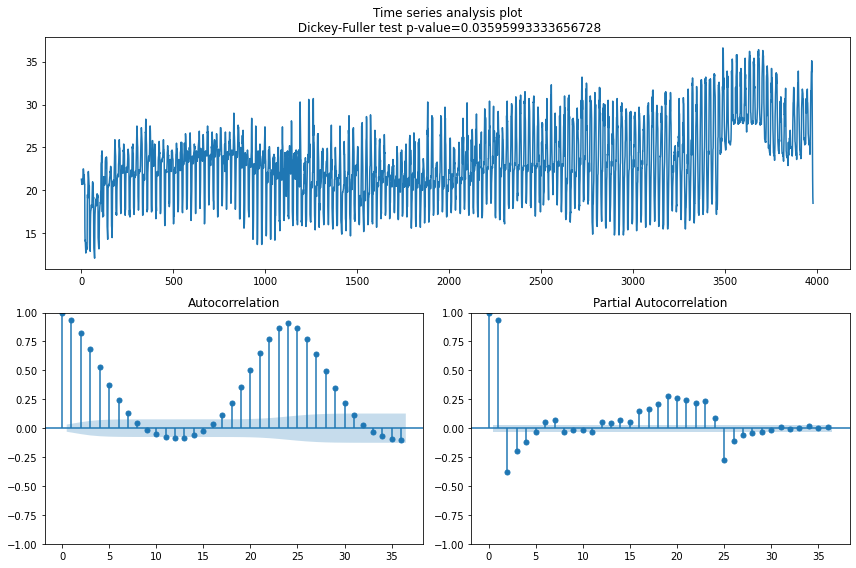

In [386]:
figure = plt.figure(figsize=(12,8))
layout = (2,2)

ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1,0))
pacf_ax = plt.subplot2grid(layout, (1,1))

y = final_df.Tair
y.plot(ax=ts_ax)

p_value = sm.tsa.stattools.adfuller(y)[1]
ts_ax.set_title(f"Time series analysis plot\n Dickey-Fuller test p-value={p_value}")

sm.graphics.tsa.plot_acf(y, lags=None, ax=acf_ax)
sm.graphics.tsa.plot_pacf(y, lags=None, ax=pacf_ax, method='ywm')
plt.tight_layout()

### Finding:
1. The p-value for the Dickey-Fuller test is 0.03 (<0.05) which suggests that we can reject the null hypothesis and assume that the data is stationary

### Model 1: **ARIMA** (Statistical)

In [422]:
model = pm.auto_arima(y, start_p=1, start_q=1,
                     test='adf',
                     max_p=9, max_q=9,
                     m=1,
                     d=None,
                     seasonal=False,
                     start_P=0,
                     D=0,
                     trace=True,
                     error_action='ignore',
                     suppress_warning=True,
                     stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14680.686, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36480.833, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=31286.036, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14522.540, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=14516.184, Time=0.53 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=14515.382, Time=0.24 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=14233.935, Time=1.99 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=14131.616, Time=1.98 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=13810.666, Ti

In [442]:
# fit the model with optimal values of p, d and q
arima_model = ARIMA(Y_train.values, order=(6,0,2))
fitted_model = arima_model.fit()

# make predictions on test dataset
Y_pred = fitted_model.forecast(len(Y_test), alpha=0.1) # make forecasts with 90% CI

# mape score
arima_mape = mean_absolute_percentage_error(Y_test, Y_pred) 

arima_acc = (1 - round(arima_mape,2)) * 100
print(f"The ARIMA model is {arima_acc} % accurate in predicting the GreehHouse Air temperature")

The ARIMA model is 80.0 % accurate in predicting the GreehHouse Air temperature


/home/soumen/projects/greenhouse-learn/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Model 2: Linear Regression (Machine Learning)

Text(0, 0.5, 'MAPE')

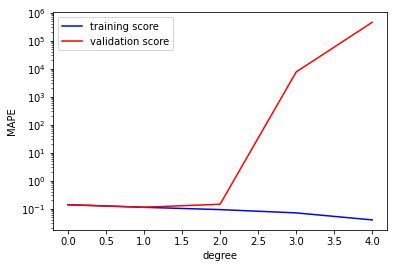

In [424]:
# Bias-variance tradeoff analysis

degree = range(0,5)

pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())

train_score, val_score = validation_curve(estimator=pipeline, 
                                         X=X_train, 
                                         y=Y_train,
                                         param_name='polynomialfeatures__degree',
                                         param_range=degree,
                                         cv=tscv,
                                         scoring='neg_mean_absolute_percentage_error')


plt.plot(degree, np.mean(-train_score, axis=1), color='blue', label='training score')
plt.plot(degree, np.mean(-val_score, axis=1), color='red', label='validation score')
plt.legend()
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('MAPE')

## Finding:
From the above plot, we find that:

    1. The model overfits for larger values (>2) of the degree of the polynomial.
    2. The model underfits for lower values (<1) of the degree of the polynomial.
    3. The sweet spot is a model with degree=1.

In [425]:
# hyperparameter tuning of Polynomial regression

param_grid = {'polynomialfeatures__degree': np.arange(5),
              'linearregression__fit_intercept': [True, False],
              }

lr = RandomizedSearchCV(pipeline, param_grid, cv=tscv)

In [426]:
lr.fit(X_train, Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('polynomialfeatures',
                                              PolynomialFeatures(degree=range(0, 5))),
                                             ('linearregression',
                                              LinearRegression())]),
                   param_distributions={'linearregression__fit_intercept': [True,
                                                                            False],
                                        'polynomialfeatures__degree': array([0, 1, 2, 3, 4])})

### Prediction on test set

In [427]:
from sklearn.metrics import mean_absolute_percentage_error

lr_pred_y = lr.predict(X_test)

lr_mape = mean_absolute_percentage_error(Y_test, lr_pred_y)
lr_acc = (1 - round(lr_mape,2)) * 100

print(f"The Linear Regression model is {lr_acc} % accurate in predicting the GreehHouse Air temperature")

The Linear Regression model is 88.0 % accurate in predicting the GreehHouse Air temperature


### Make forecast plot and add confidence interval

Text(0, 0.5, 'Temperature')

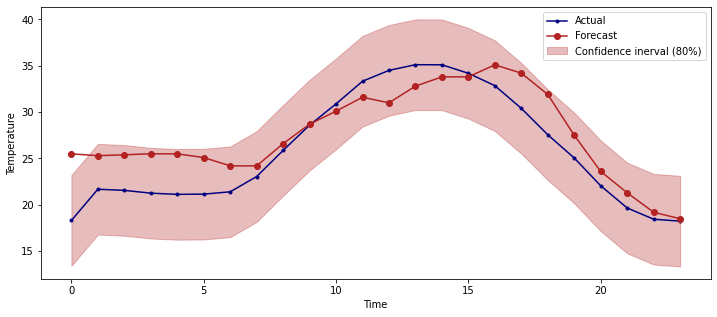

In [470]:
ci_u, ci_l = confidence_interval(Y_test, lr_pred_y, 0.8)

figure = plt.figure(figsize=(12,5))
plt.plot(lr_pred_y[-24:], marker='.',label="Actual",color='navy')
plt.plot(Y_test.values[-24:] ,marker='o',label="Forecast",color='firebrick')
plt.fill_between(np.arange(0,24,1), ci_l[-24:], ci_u[-24:],alpha=0.3, label = 'Confidence inerval (80%)',color='firebrick')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature')

In [431]:
len(lr_pred_y)

1194

### Model 3: XGBoost (Machine learning)

In [472]:
# hyperparameter tuning using Grid search

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    "max_depth": [3, 4, 5, 10, 25],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "n_estimators": [50, 100, 150],
    'min_child_weight': [1, 2, 5],
    'gamma': [0, 0.1, 0.5, 1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.9, 0.95, 1.0],
}
xgb_rgs = XGBRegressor(random_state=42)

xgb_gs = RandomizedSearchCV(xgb_rgs, 
                           n_jobs=6, 
                           n_iter=500,
                           param_distributions=param_dist, 
                           cv = tscv, 
                           scoring="neg_mean_absolute_percentage_error", 
                           verbose=0)

xgb_gs.fit(X_train, Y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=...
                                          predictor=None, random_state=42,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=500, n_jobs=6,
                   param_distributions={'colsample_bytree': [0.9, 0.95, 1.0],
                                        'gamma': [0, 0.1, 0.5, 1.5],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [3, 4, 5, 10, 25],
                                        'min_child_weight': [1, 2, 5],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_absolute_percentage_error')

In [434]:
xgb_gs.best_params_

{'subsample': 1.0,
 'n_estimators': 100,
 'min_child_weight': 2,
 'max_depth': 4,
 'learning_rate': 0.05,
 'gamma': 1.5,
 'colsample_bytree': 0.9}

In [435]:
xgb_model = XGBRegressor(subsample=1.0,
                         n_estimators=100,
                         min_child_weight=2,
                         max_depth=4,
                         learning_rate=0.05,
                         gamma=1.5,
                         colsample_bytree=0.9)

In [438]:
y_pred = xgb_model.predict(X_test)

In [440]:
# test error rate 
xgb_mape = mean_absolute_percentage_error(Y_test, y_pred)

xgb_acc = (1 - round(xgb_mape,2)) * 100

print(f"The XGBoost model is {xgb_acc} % accurate in predicting the GreehHouse Air temperature")

The XGBoost model is 88.0 % accurate in predicting the GreehHouse Air temperature


### Model 4: LSTM

### Add time aspect to the dataset to make it compatible with LSTM

In [443]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2785, 11), (2785,), (1194, 11), (1194,))

In [444]:
# prepare the dataset for the LSTM model: add the time steps

def prepare_data_lstm(X, Y, time_steps=1):
    Xs = []
    Ys = []
    for i in tqdm(range(len(X) - time_steps)):
        a = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(a)
        Ys.append(Y.iloc[i+time_steps])
    return np.array(Xs),np.array(Ys)    

steps=288 # Each hour in a day (5*12*24)

X_train_lstm , Y_train_lstm = prepare_data_lstm(X_train,Y_train,time_steps=steps)
X_test_lstm , Y_test_lstm = prepare_data_lstm(X_test,Y_test,time_steps=steps)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 906/906 [00:00<00:00, 13880.05it/s]


In [446]:
X_train_lstm.shape, Y_train_lstm.shape, X_test_lstm.shape, Y_test_lstm.shape

((2497, 288, 11), (2497,), (906, 288, 11), (906,))

In [447]:
# initialize a Bi-directional LSTM model 

model = Sequential()
model.add(Bidirectional(CuDNNLSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1],X_train_lstm.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="mse")

## NOTE: This cell was run on google colab because of absence of GPU on local machine. The trained model is downloaded.

In [415]:
# lstm_model = model.fit(X_train_lstm,Y_train_lstm,batch_size=32,epochs=20,validation_data=(X_test_lstm,Y_test_lstm))

In [449]:
# error rate

lstm_model = load_model("../model/lstm_model.h5")

# y_pred_lstm = lstm_model.predict(X_test_lstm)
# mean_absolute_percentage_error(Y_test_lstm, y_pred_lstm)

# fetch the mape value from google colab
lstm_mape = 0.18
lstm_acc = (1 - round(lstm_mape,2)) * 100

print(f"The LSTM model is {lstm_acc} % accurate in predicting the GreehHouse Air temperature")

The LSTM model is 82.0 % accurate in predicting the GreehHouse Air temperature


## Finding:
Comparing the MAPE scores for all the 4 models, we find that **XGBoost performs the best** in our prediction task. Hence, we use the XGBoost model for our task.

In [451]:
joblib.dump(xgb_model, 'GREENHOUSE_PREDICTION.model')

['GREENHOUSE_PREDICTION.model']

## Biggest shortcoming of the model:
**Problem**: 
1. The model currently has low cross validation error but high test error because the test dataset contains outliers or seasonal data which train dataset doesn't have.
2. Not able to penalize forecasts.

**Solution**: 
1. Add annual dataset
2. Add Weighted Quantile loss as accuracy metric

## NOTE:

We could've resampled the original dataset to convert it to hourly dataset but that would reduce the number of data points from 47k to 4k for training our model. Instead, we train our models on 5min interval dataset and adjust out model output by converting in the results to hour scale.